# Building simple LogisticRegression models

This notebook:
* builds several simple LogisticRegression models to experiment with performance in response to different formats of input data
* performs a GridSearchCV to obtain the best hyperparameters for a LogisticRegression model

In [1]:
from modules.utility import Utility
from IPython.display import display
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import pickle

In [2]:
## Uncomment code as required to force reload utility.py
## Was only required during development of this notebook

# from importlib import reload
# import modules.utility
# reload(modules.utility)
# from modules.utility import Utility

# Setup

Remove display limits for column and row lengths, for easier viewing of dataframes

In [3]:
# Set no limits for number of columns and rows to display
# Utility.reset_display_max_cols_rows() to reset
Utility.setup_display_max_cols_rows()

Load the cleaned data

In [4]:
# Load the final, melted, cleaned dataset
df = Utility.get_clean_waittimes_dataframe()
df.head()

,datetime,hospital,waittime,year,dayofweek,numdayofweek,weekofyear,hour,dayperiod,id,services,city,cityarea,citypop,citytype,hosplat,hosplong
0,2022-09-24 18:22:00,Alberta Children's Hospital,201.0,2022,Saturday,5,38,18,evening,ach,emergency,Calgary,826,1306784,urban,51.074759,-114.146833
1,2022-09-24 18:22:00,Chinook Regional Hospital,69.0,2022,Saturday,5,38,18,evening,crh,emergency,Lethbridge,122,98406,peri,49.685221,-112.816209
2,2022-09-24 18:22:00,Devon General Hospital,132.0,2022,Saturday,5,38,18,evening,dgh,emergency,Devon,14,6545,rural,53.352265,-113.728288
3,2022-09-24 18:22:00,Foothills Medical Centre,188.0,2022,Saturday,5,38,18,evening,fmc,emergency,Calgary,826,1306784,urban,51.064657,-114.130926
4,2022-09-24 18:22:00,Fort Sask Community Hospital,295.0,2022,Saturday,5,38,18,evening,fsch,emergency,Fort Saskatchewan,48,27088,rural,53.693175,-113.213436


In [5]:
# Original df shape
df.shape

(201151, 17)

Remove 'Urgent Care' facilities so we are only modelling on ERs

In [6]:
# Filter the dataframe to be only Emergency services
ER_SERVICES_MASK = Utility.MASK_EMERGENCY_SERVICES(df)
df = df[ER_SERVICES_MASK]

In [7]:
# df shape after dropping 'urgentcare' services
df.shape

(181926, 17)

# Prepare data for modeling

Try a logistic regression classification learning model where y = binary outcome of long wait, where I have **defined long wait as "greater than 400 minutes (6.67 hours)"**.

This '400 minute' choice was based on the following:
* Looking at the descriptive statistics for the entire dataset or ER hospitals
* Calculating the upper bound for outliers (`Q3 + IQR*1.5`) cut off for ER hospitals (500 minutes)
* The following national guidelines, with images shown in readme.md:
    - Canadian ED Triage & Acuity Scale, 1998: https://ctas-phctas.ca/wp-content/uploads/2018/05/ctased16_98.pdf
        - Specifying lowest triage level (Level V) should have time to physician <= 2 hours
    - CAEP (Canadian Associate of Emergency Physicians) Position Statement, 2013: "Emergency department overcrowding and access block":  https://caep.ca/wp-content/uploads/2016/03/cjem_2013_overcrowding_and_access_block.pdf
        - Specifying recommendation for median 1 hour to PIA and 3 hours at 90% percentile
    - Alberta Health Performance Measure Definition for TPIA (Time to Physician Initial Assessment) (Feb 2015): https://open.alberta.ca/dataset/c7e3fc16-7aea-455c-96a1-20811a640b1a/resource/e2f49c22-3390-48a3-ac74-278a932aa668/download/pmd-ed-time-physician-initial-assessment.pdf
        - Specifying national sides averaging 3.2 hours, Alberta sites averaging 3.1 hours (in 2012-13)
    - "Physician Initial Assessment Times Based on CTAS Scores: Are We Meeting the Recommendations?": https://www.longwoods.com/content/26333/healthcare-quarterly/physician-initial-assessment-times-based-on-ctas-scores-are-we-meeting-the-recommendations-
        - Specifying "overall compliance with recommended PIA times was low" in 4 community EDs around Hamilton, Ontario from 2016-2017.


Feature Engineer:
* longwait: 0 or 1

Drop:
* datetime
* hospital (we will use 'id' instead)
* waittime (we are using our binary value of 'longwait' instead, because this is a classification problem)
* year
* numdayofweek (we will use 'dayofweek' instead)
* services (they are all 'emergency' based on our earlier filter)
* cityarea
* citypop
* hosplat
* hosplong

We will also do additional feature engineering to simplify features:
* collapse citytype 'peri' into 'rural', and keep this feature

**NOTE: I have defined constants and utility functions in the `Utility` class in `modules.utility` (modules/utility.py file) to ensure consistency in shaping the dataframe that is ultimately used for modelling, in each classifier I build.**

In [8]:
# Create new dataframe called df_model
df_model = df.copy()

# Collapse citytype 'peri' into 'rural'.  This is a valid assumption as demonstrated by plots in the erwait_eda_hypothesis_testing.ipynb notebook.
Utility.collapse_periurban_to_rural(df_model)

# Engineer the new feature 'longwait'
Utility.add_longwait_feature(df_model)

# Drop unwanted columns, which are defined as Utility.LOGIT_DROP_COLS, for consistent use in every notebook for every classification model.
Utility.drop_unwanted_columns(df_model, Utility.LOGIT_DROP_COLS)

Confirm how the dataframe looks after:
* Collapsing peri to rural
* Adding the 'longwait' feature (this will be our target variable)
* Dropping unwanted columns/features

In [9]:
Utility.display_df_general_info(df_model)
# display(df_model.head())
# print(f"\nShape of df_model: {df_model.shape}")
# print(f"\nColumns of df_model: {df_model.columns}")
# print(f"\ndtypes of df_model: {df_model.dtypes}")

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Saturday,38,18,evening,ach,Calgary,urban,0
1,Saturday,38,18,evening,crh,Lethbridge,rural,0
2,Saturday,38,18,evening,dgh,Devon,rural,0
3,Saturday,38,18,evening,fmc,Calgary,urban,0
4,Saturday,38,18,evening,fsch,Fort Saskatchewan,rural,0



Shape of dataframe:
(181926, 8)

Columns of dataframe:
Index(['dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city',
       'citytype', 'longwait'],
      dtype='object')

dtypes of dataframe:
dayofweek     object
weekofyear     int64
hour           int64
dayperiod     object
id            object
city          object
citytype      object
longwait       int64
dtype: object


Sort the dataframe a consistent and particular way (as defined in Utility class) prior to one-hot encoding, so that the one-hot encoding is consistent across all notebooks for all classification models.

In [10]:
df_model = Utility.sort_df_before_encoding_or_modeling(df_model)

Check what it looks like after sorting


In [11]:
df_model.head()

,dayofweek,weekofyear,hour,dayperiod,id,city,citytype,longwait
0,Friday,1,0,night,ach,Calgary,urban,0
1,Friday,1,0,night,crh,Lethbridge,rural,0
2,Friday,1,0,night,dgh,Devon,rural,0
3,Friday,1,0,night,fmc,Calgary,urban,1
4,Friday,1,0,night,fsch,Fort Saskatchewan,rural,0


# Modelling Plans

We will build 4 logistic regression models and compare results as follows:

| Model Name | Feature Columns                                                                                                                            | Target Column | One-Hot Encoded Columns                                                              | Datatypes of columns not one-hot encoded | Datatypes of non-one-hot-encoded columns     | Class Counts                                                     | Main Question                                                                              |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------|---------------|--------------------------------------------------------------------------------------|------------------------------------------|----------------------------------------------|------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| baseline   | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype' | 'weekofyear', 'hour'                     | 'hour': category      'weekofyear': category | Imbalanced: '1': 93.3%, '0': 6.7%                                | What is baseline performance for basic LogisticRegression model?                           |
| balanced   | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype' | 'weekofyear', 'hour'                     | 'hour': category      'weekofyear': category | More balanced (SMOTE/RandomUnderSampler): '1': 66.7%, '0': 33.3% | What is performance when using balanced classes?                                           |
| hourint   | 'dayofweek', 'weekofyear', 'hour', 'dayperiod', 'id', 'city', 'citytype'                                                                   | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_A:      'dayofweek', 'dayperiod', 'id', 'city', 'citytype' | 'weekofyear', 'hour'                     | 'hour': int      'weekofyear': category      | More balanced (SMOTE/RandomUnderSampler): '1': 66.7%, '0': 33.3% | Does making hour an integer increase performance?                                          |
| simplify   | Remove 'dayperiod' from columns,   as it is collinear:      Resulting cols = 'dayofweek', 'weekofyear', 'hour', 'id', 'city',   'citytype' | 'longwait'    | Utility.LOGIT_ONEHOT_COLS_B:      'dayofweek', 'id', 'city', 'citytype'              | 'weekofyear', 'hour'                     | 'hour': int      'weekofyear': category | More balanced (SMOTE/RandomUnderSampler): '1': 66.7%, '0': 33.3% | Does removing the 'dayperiod' which is multicollinear with 'hour',   increase performance? |

# Model: "baseline"

One-hot encoding and turning booleans into 0's and 1's

In [12]:
# One-hot encoding of categorical columns as defined in Utility function (LOGIT_ONEHOT_COLS_A includes 'dayperiod')
df_model = Utility.one_hot_encode_categorical_columns(df_model, Utility.LOGIT_ONEHOT_COLS_A)

# Turn booleans into 0's and 1'
Utility.convert_booleans(df_model)

Convert 'hour' and 'weekofyear' to category types

In [13]:
df_model['hour'] = df_model['hour'].astype('category')
df_model['weekofyear'] = df_model['weekofyear'].astype('category')

How does the dataframe look?

In [14]:
Utility.display_df_general_info(df_model)

,weekofyear,hour,longwait,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0



Shape of dataframe:
(181926, 41)

Columns of dataframe:
Index(['weekofyear', 'hour', 'longwait', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayperiod_evening',
       'dayperiod_night', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch',
       'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah', 'id_rdrh',
       'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery', 'id_uah',
       'id_whc', 'city_Devon', 'city_Edmonton', 'city_Fort Saskatchewan',
       'city_Leduc', 'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                      category
longwait                     int64
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofwee

## Set X and y dataframes for all models

In [15]:
X_model = (df_model.drop(['longwait'], axis=1))
y_model = (df_model['longwait'])

## Train-Test Split for Model: "baseline"

In [16]:
# Make 80% training, 20% testing and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

In [17]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split

In [18]:
Utility.display_class_balance(y_train, y_test)

y_train_counter: Counter({0: 135805, 1: 9735}), 0: 93.31111721863405, 1: 6.6888827813659475
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


## Build Logistic Regression model: "baseline"

In [19]:
baseline_clf = LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000)
baseline_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [20]:
# Get predictions for X_train and X_test
y_train_pred = baseline_clf.predict(X_train)
y_test_pred = baseline_clf.predict(X_test)

## Evaluate model performance: "baseline"

Confusion Matrix

In [21]:
# Confusion Matrix
print("\nResults on TRAINING data:")
baseline_train_cm = Utility.print_confusion_matrix_with_labels(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,34,9701
Actual Negative,26,135779



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,8,2515
Actual Negative,5,33858


ROC Curve


Results on TRAINING data:


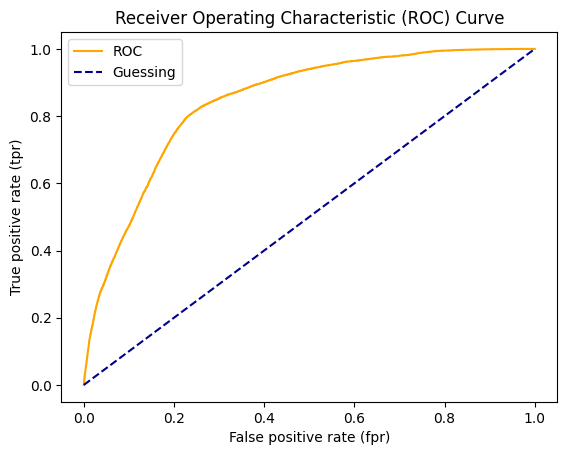


Results on TEST data:


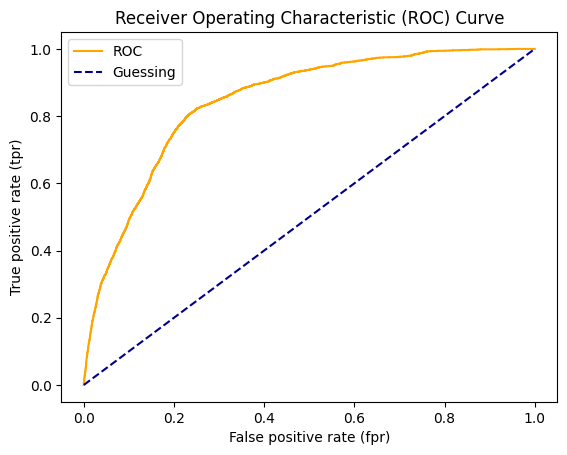

In [22]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = baseline_clf.predict_proba(X_train)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = baseline_clf.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [23]:
# Scores
print("\nResults on TRAINING data:")
baseline_train_scores = Utility.evaluate_preds(y_train, y_train_pred)

print("\nResults on TEST data:")
baseline_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      93.32%
Precision           :       0.57
Recall              :       0.00
F1 score            :       0.01
F1 (macro) score    :       0.49
F1 (weighted) score :       0.90
ROC-AUC             :       0.50

Results on TEST data:
Accuracy            :      93.07%
Precision           :       0.62
Recall              :       0.00
F1 score            :       0.01
F1 (macro) score    :       0.49
F1 (weighted) score :       0.90
ROC-AUC             :       0.50


# Model: "balanced"

## Need to Oversample the minority class and undersample entire dataset

Code idea/credit: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

(I made a couple tweaks!)

In [24]:
# Use the same X_train and y_train from the "baseline" code above, since nothing needs to change about the features included, nor the encoding.
over = SMOTE(sampling_strategy=0.10, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under = IMBPipeline(steps=steps)
X_train_balanced, y_train_balanced = imbpipeline_sm_under.fit_resample(X_train, y_train)

In [25]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_train_balanced.shape[0]: {X_train_balanced.shape[0]}")
print(f"y_train_balanced.shape[0]: {y_train_balanced.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_train_balanced.shape[0]: 40740
y_train_balanced.shape[0]: 40740
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the train_test_split

In [26]:
Utility.display_class_balance(y_train_balanced, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


## Build Logistic Regression model: "balanced"

In [27]:
balanced_clf = LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000)
balanced_clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [28]:
# Get predictions for X_train and X_test
y_train_pred = balanced_clf.predict(X_train_balanced)
y_test_pred = balanced_clf.predict(X_test)

## Evaluate model performance: "balanced"

Confusion Matrix

In [29]:
# Confusion Matrix
print("\nResults on TRAINING data:")
balanced_train_cm = Utility.print_confusion_matrix_with_labels(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
balanced_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9018,4562
Actual Negative,4205,22955



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1587,936
Actual Negative,5245,28618


ROC Curve


Results on TRAINING data:


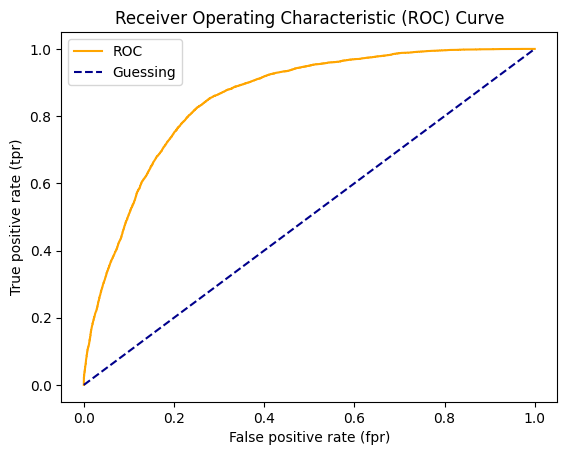


Results on TEST data:


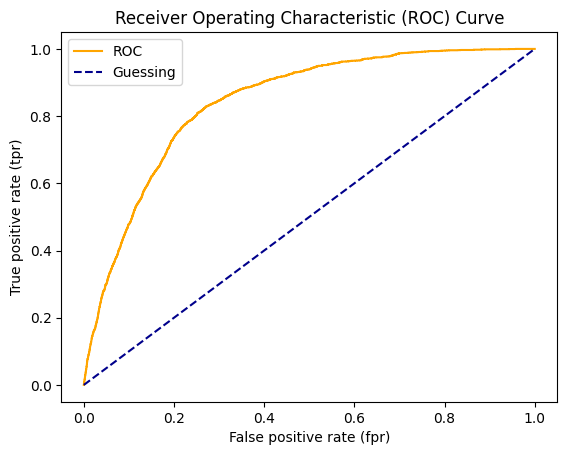

In [30]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = balanced_clf.predict_proba(X_train_balanced)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_balanced, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = balanced_clf.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [31]:
# Scores
print("\nResults on TRAINING data:")
balanced_train_scores = Utility.evaluate_preds(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
balanced_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      78.48%
Precision           :       0.68
Recall              :       0.66
F1 score            :       0.67
F1 (macro) score    :       0.76
F1 (weighted) score :       0.78
ROC-AUC             :       0.75

Results on TEST data:
Accuracy            :      83.01%
Precision           :       0.23
Recall              :       0.63
F1 score            :       0.34
F1 (macro) score    :       0.62
F1 (weighted) score :       0.86
ROC-AUC             :       0.74


# Model: "hourint"

Recall this experiement/model has these characteristics:
* 'hour' will be turned into an int instead of 'category' datatype
* still using X_train_balanced, y_train_balanced which is from `SMOTE` and `RandomUnderSampler` use to reduce class imbalance

Convert 'hour' to `int` dtype

In [32]:
X_train_balanced['hour'] = X_train_balanced['hour'].astype('int')
X_test['hour'] = X_test['hour'].astype('int')

#X_train_balanced['weekofyear'] = X_train_balanced['weekofyear'].astype('category')  # This is already in place from earlier cells
#X_test['weekofyear'] = X_test['weekofyear'].astype('category')  # This is already in place from earlier cells

How does the dataframe look?
* X_train_balanced
* X_test

In [33]:
Utility.display_df_general_info(X_train_balanced)
Utility.display_df_general_info(X_test)

,weekofyear,hour,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
45007,50,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
35862,12,19,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
118714,21,6,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
129681,40,3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
143602,35,8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0



Shape of dataframe:
(40740, 40)

Columns of dataframe:
Index(['weekofyear', 'hour', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'dayperiod_evening', 'dayperiod_night', 'id_crh',
       'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch', 'id_lch', 'id_mch', 'id_mhrh',
       'id_nchc', 'id_plc', 'id_rah', 'id_rdrh', 'id_rgh', 'id_sch', 'id_schc',
       'id_shc', 'id_stollery', 'id_uah', 'id_whc', 'city_Devon',
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                         int32
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday    

,weekofyear,hour,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,dayperiod_evening,dayperiod_night,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
109432,12,23,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
59969,18,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61225,21,5,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
117768,34,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75800,49,6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1



Shape of dataframe:
(36386, 40)

Columns of dataframe:
Index(['weekofyear', 'hour', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'dayperiod_evening', 'dayperiod_night', 'id_crh',
       'id_dgh', 'id_fmc', 'id_fsch', 'id_gnch', 'id_lch', 'id_mch', 'id_mhrh',
       'id_nchc', 'id_plc', 'id_rah', 'id_rdrh', 'id_rgh', 'id_sch', 'id_schc',
       'id_shc', 'id_stollery', 'id_uah', 'id_whc', 'city_Devon',
       'city_Edmonton', 'city_Fort Saskatchewan', 'city_Leduc',
       'city_Lethbridge', 'city_Medicine Hat', 'city_Red Deer',
       'city_Sherwood Park', 'city_St. Albert', 'city_Stony Plain',
       'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                         int32
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday    

In [34]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_train_balanced.shape[0]: {X_train_balanced.shape[0]}")
print(f"y_train_balanced.shape[0]: {y_train_balanced.shape[0]}")

print(f"X_test.shape[0]: {X_test.shape[0]}")
print(f"y_test.shape[0]: {y_test.shape[0]}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_train_balanced.shape[0]: 40740
y_train_balanced.shape[0]: 40740
X_test.shape[0]: 36386
y_test.shape[0]: 36386


Check class distributions in y_train and y_test after the SMOTE and RandomUnderSampler and train_test_split 

In [35]:
Utility.display_class_balance(y_train_balanced, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


## Build Logistic Regression model: "hourint"

In [36]:
hourint_clf = LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000)
hourint_clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
# Get predictions for X_train and X_test
y_train_pred = hourint_clf.predict(X_train_balanced)
y_test_pred = hourint_clf.predict(X_test)

## Evaluate model performance: "hourint"

Confusion Matrix

In [38]:
# Confusion Matrix
print("\nResults on TRAINING data:")
hourint_train_cm = Utility.print_confusion_matrix_with_labels(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
hourint_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,9018,4562
Actual Negative,4205,22955



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1587,936
Actual Negative,5245,28618


ROC Curve


Results on TRAINING data:


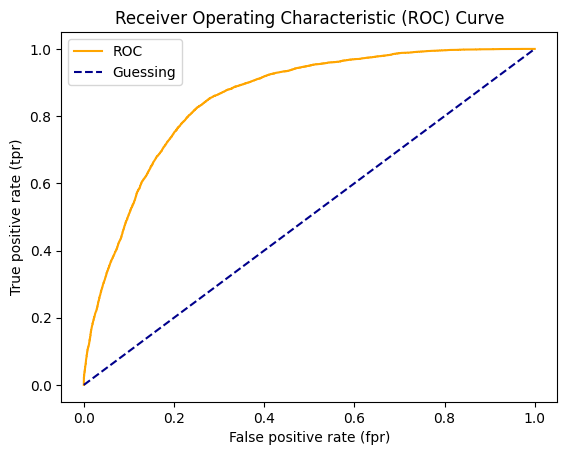


Results on TEST data:


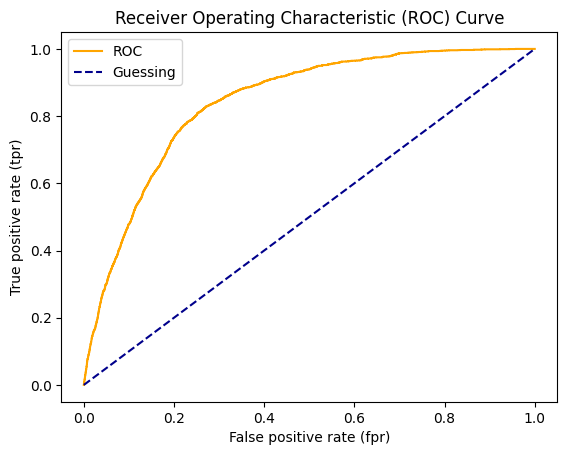

In [39]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = hourint_clf.predict_proba(X_train_balanced)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_balanced, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = hourint_clf.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [40]:
# Scores
print("\nResults on TRAINING data:")
hourint_train_scores = Utility.evaluate_preds(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
hourint_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      78.48%
Precision           :       0.68
Recall              :       0.66
F1 score            :       0.67
F1 (macro) score    :       0.76
F1 (weighted) score :       0.78
ROC-AUC             :       0.75

Results on TEST data:
Accuracy            :      83.01%
Precision           :       0.23
Recall              :       0.63
F1 score            :       0.34
F1 (macro) score    :       0.62
F1 (weighted) score :       0.86
ROC-AUC             :       0.74


Finding: Changing the 'hour' to an int type did not appear to affect the model performance/scores at all.

# Model: "simplify"

Recall this experiement/model has these characteristics:
* 'hour' will be turned into `int` datatype (Note: I later checked, and confirmed it doesn't make any difference in this scenario if `hour` is a `category`)
* the 'dayperiod' column, which is collinear with the 'hour' column, is removed
    - this can more easily be done without starting from the original non-one-hot-encoded dataframe, by removing the one-hot-encoded columns associated to 'dayperiod' for each of `X_train_balanced` and `X_test_balanced`, which are:
        - 'dayperiod_evening'
        - 'dayperiod_night'
* still using X_train_balanced, y_train_balanced which is from `SMOTE` and `RandomUnderSampler` use to reduce class imbalance

Ensure 'hour' is to `int` dtype in both:
* X_train_balanced
* X_test

In [41]:
X_train_balanced['hour'] = X_train_balanced['hour'].astype('int')
X_test['hour'] = X_test['hour'].astype('int')

#X_train_balanced['hour'] = X_train_balanced['hour'].astype('category')  # I did try this later; it made no difference to model evaluation scores
#X_test['hour'] = X_test['hour'].astype('category')  # I did try this later; it made no difference to model evaluation scores

#X_train_balanced['weekofyear'] = X_train_balanced['weekofyear'].astype('category')  # This is already in place from initial preparation of data before 'baseline' model
#X_test['weekofyear'] = X_test['weekofyear'].astype('category') # This is already in place from initial preparation of data before 'baseline' model

Remove `dayperiod_evening` and `dayperiod_night` columns from X_train_balanced and X_test

In [42]:
X_train_balanced_simplify = X_train_balanced.copy()
X_train_balanced_simplify.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)

X_test_simplify = X_test.copy()
X_test_simplify.drop(['dayperiod_evening', 'dayperiod_night'], axis=1, inplace=True)

How does the dataframe look?
* X_train_balanced_simplify
* X_test_simplify

In [43]:
Utility.display_df_general_info(X_train_balanced_simplify)
Utility.display_df_general_info(X_test_simplify)

,weekofyear,hour,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
45007,50,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
35862,12,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
118714,21,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
129681,40,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
143602,35,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0



Shape of dataframe:
(40740, 38)

Columns of dataframe:
Index(['weekofyear', 'hour', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch',
       'id_gnch', 'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah',
       'id_rdrh', 'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery',
       'id_uah', 'id_whc', 'city_Devon', 'city_Edmonton',
       'city_Fort Saskatchewan', 'city_Leduc', 'city_Lethbridge',
       'city_Medicine Hat', 'city_Red Deer', 'city_Sherwood Park',
       'city_St. Albert', 'city_Stony Plain', 'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                         int32
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday            int32
dayofweek_Wednesday          int3

,weekofyear,hour,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,id_crh,id_dgh,id_fmc,id_fsch,id_gnch,id_lch,id_mch,id_mhrh,id_nchc,id_plc,id_rah,id_rdrh,id_rgh,id_sch,id_schc,id_shc,id_stollery,id_uah,id_whc,city_Devon,city_Edmonton,city_Fort Saskatchewan,city_Leduc,city_Lethbridge,city_Medicine Hat,city_Red Deer,city_Sherwood Park,city_St. Albert,city_Stony Plain,citytype_urban
109432,12,23,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
59969,18,14,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61225,21,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
117768,34,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75800,49,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1



Shape of dataframe:
(36386, 38)

Columns of dataframe:
Index(['weekofyear', 'hour', 'dayofweek_Monday', 'dayofweek_Saturday',
       'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday',
       'dayofweek_Wednesday', 'id_crh', 'id_dgh', 'id_fmc', 'id_fsch',
       'id_gnch', 'id_lch', 'id_mch', 'id_mhrh', 'id_nchc', 'id_plc', 'id_rah',
       'id_rdrh', 'id_rgh', 'id_sch', 'id_schc', 'id_shc', 'id_stollery',
       'id_uah', 'id_whc', 'city_Devon', 'city_Edmonton',
       'city_Fort Saskatchewan', 'city_Leduc', 'city_Lethbridge',
       'city_Medicine Hat', 'city_Red Deer', 'city_Sherwood Park',
       'city_St. Albert', 'city_Stony Plain', 'citytype_urban'],
      dtype='object')

dtypes of dataframe:
weekofyear                category
hour                         int32
dayofweek_Monday             int32
dayofweek_Saturday           int32
dayofweek_Sunday             int32
dayofweek_Thursday           int32
dayofweek_Tuesday            int32
dayofweek_Wednesday          int3

In [44]:
# Check what are the types and numbers in each of the 6 items I just created:
print(f"type(X_model): {type(X_model)}")
print(f"type(y_model): {type(y_model)}")

print(f"type(X_train): {type(X_train)}")
print(f"type(y_train): {type(y_train)}")

print(f"type(X_test): {type(X_test)}")
print(f"type(y_test): {type(y_test)}")

print(f"X_model.shape[0]: {X_model.shape[0]}")
print(f"y_model.shape[0]: {y_model.shape[0]}")

print(f"X_train.shape[0]: {X_train.shape[0]}")
print(f"y_train.shape[0]: {y_train.shape[0]}")

print(f"X_train_balanced.shape: {X_train_balanced.shape}")
print(f"X_train_balanced_simplify.shape: {X_train_balanced_simplify.shape}")
print(f"y_train_balanced.shape: {y_train_balanced.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"X_test_simplify.shape: {X_test_simplify.shape}")
print(f"y_test.shape: {y_test.shape}")

type(X_model): <class 'pandas.core.frame.DataFrame'>
type(y_model): <class 'pandas.core.series.Series'>
type(X_train): <class 'pandas.core.frame.DataFrame'>
type(y_train): <class 'pandas.core.series.Series'>
type(X_test): <class 'pandas.core.frame.DataFrame'>
type(y_test): <class 'pandas.core.series.Series'>
X_model.shape[0]: 181926
y_model.shape[0]: 181926
X_train.shape[0]: 145540
y_train.shape[0]: 145540
X_train_balanced.shape: (40740, 40)
X_train_balanced_simplify.shape: (40740, 38)
y_train_balanced.shape: (40740,)
X_test.shape: (36386, 40)
X_test_simplify.shape: (36386, 38)
y_test.shape: (36386,)


Check class distributions in y_train and y_test after the train_test_split

In [45]:
Utility.display_class_balance(y_train_balanced, y_test)

y_train_counter: Counter({0: 27160, 1: 13580}), 0: 66.66666666666666, 1: 33.33333333333333
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


## Build Logistic Regression model: "simplify"

In [46]:
simplify_clf = LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000)
simplify_clf.fit(X_train_balanced_simplify, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [47]:
# Get predictions for X_train and X_test
y_train_pred = simplify_clf.predict(X_train_balanced_simplify)
y_test_pred = simplify_clf.predict(X_test_simplify)

## Evaluate model performance: "simplify"

Confusion Matrix

In [48]:
# Confusion Matrix
print("\nResults on TRAINING data:")
simplify_train_cm = Utility.print_confusion_matrix_with_labels(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
simplify_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,6975,6605
Actual Negative,4195,22965



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1208,1315
Actual Negative,5163,28700


ROC Curve


Results on TRAINING data:


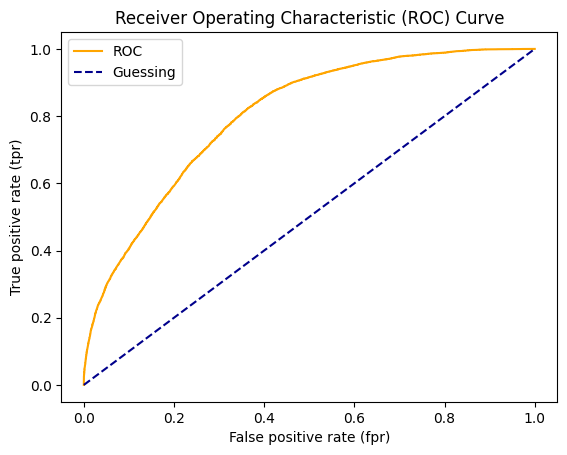


Results on TEST data:


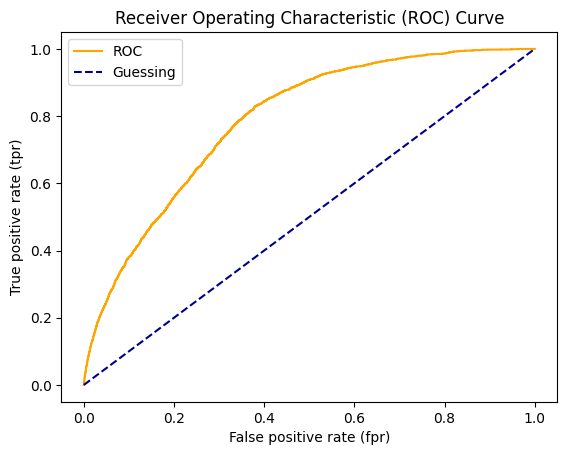

In [49]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = simplify_clf.predict_proba(X_train_balanced_simplify)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_balanced, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = simplify_clf.predict_proba(X_test_simplify)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [50]:
# Scores
print("\nResults on TRAINING data:")
simplify_train_scores = Utility.evaluate_preds(y_train_balanced, y_train_pred)

print("\nResults on TEST data:")
simplify_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      73.49%
Precision           :       0.62
Recall              :       0.51
F1 score            :       0.56
F1 (macro) score    :       0.69
F1 (weighted) score :       0.73
ROC-AUC             :       0.68

Results on TEST data:
Accuracy            :      82.20%
Precision           :       0.19
Recall              :       0.48
F1 score            :       0.27
F1 (macro) score    :       0.59
F1 (weighted) score :       0.86
ROC-AUC             :       0.66


Finding: Removing the 'dayperiod' feature seems to have reduced the F1 (macro) and ROC-AUC scores from the previous model runs.

# Evaluate performance of all models

In [51]:
df_compare = pd.DataFrame({
    'baseline_train': baseline_train_scores,
    'baseline_test': baseline_test_scores,
    'balanced_train': balanced_train_scores,
    'balanced_test': balanced_test_scores,
    'hourint_train': hourint_train_scores,
    'hourint_test': hourint_test_scores,
    'simplify_train': simplify_train_scores,
    'simplify_test': simplify_test_scores})

df_compare

,baseline_train,baseline_test,balanced_train,balanced_test,hourint_train,hourint_test,simplify_train,simplify_test
accuracy,0.93,0.93,0.78,0.83,0.78,0.83,0.73,0.82
precision,0.57,0.62,0.68,0.23,0.68,0.23,0.62,0.19
recall,0.00,0.00,0.66,0.63,0.66,0.63,0.51,0.48
f1,0.01,0.01,0.67,0.34,0.67,0.34,0.56,0.27
f1_macro,0.49,0.49,0.76,0.62,0.76,0.62,0.69,0.59
f1_weighted,0.90,0.90,0.78,0.86,0.78,0.86,0.73,0.86
roc_auc,0.50,0.50,0.75,0.74,0.75,0.74,0.68,0.66


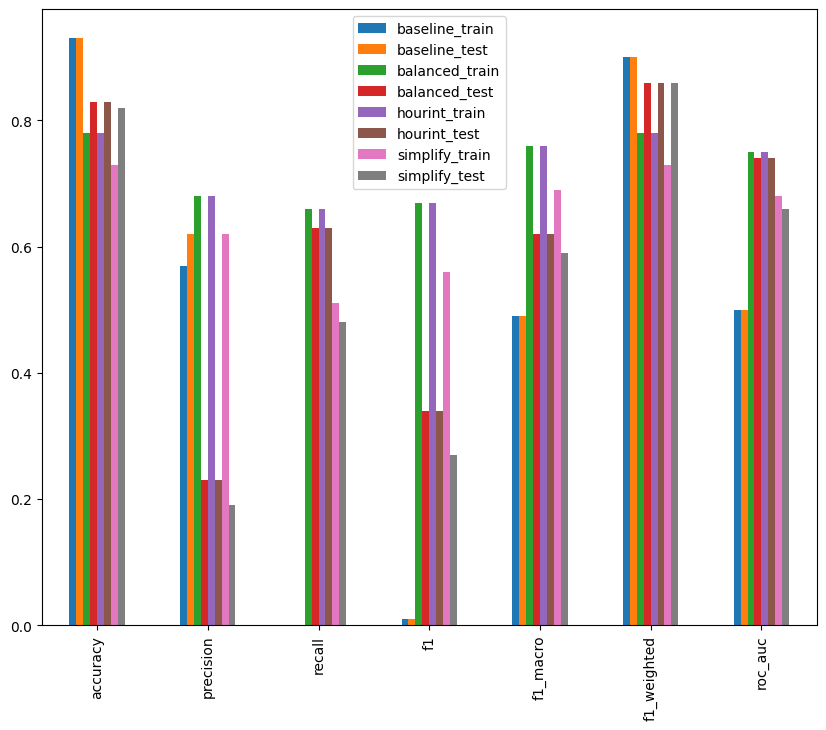

In [404]:
# Plot the scores
df_compare.plot.bar(figsize=(10,8));

Finding:  The above shows that the "balanced original" situation (without removing `dayperiod` feature) performed the best for both F1 Macro and roc_auc score on both train and test datasets.

Though I ran the 'simplify' model with no 'dayperiod' and 'hour' turned into an `int`, it turns out that there were no changes to model evaluation scores whether `hour` was an `int` or a `category`.

# Can We Do Better on Logistic Regression Balanced Model?

From the above, it is clear that the "balanced original" situation did best.

Can we run this model in a GridSearchCV, using an exhaustive search against the `sampling_strategy` parameters for SMOTE and RandomUnderSampler?

In [321]:
### PLEASE NOTE:  The below did not work because of the way GridSearchCV works with imblearn.pipeline on the RandomUnderSampler() class.
### See stackoverflow thread here:  https://stackoverflow.com/questions/65652054/not-able-to-feed-the-combined-smote-randomundersampler-pipeline-into-the-main
### I addressed by collapsing all 3 into one singular imlearn.pipeline (next cell)
### I have left the code here for reference only.

# # Just to be sure everything has returned to base, let's re-make the X_train and y_train, X_test, y_test variables
# X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

# # Define the imbalanced pipeline with SMOTE and RandomUnderSampler again
# imbalanced_pipeline = IMBPipeline([
#     ('smote', SMOTE(sampling_strategy=0.1, random_state=Utility.RANDOM_STATE_CONST)),
#     ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)),
# ])

# # Combine the imbalanced pipeline with Logistic Regression
# pipeline = IMBPipeline([
#     ('imbalanced', imbalanced_pipeline),
#     ('clf', LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000))
# ])

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'imbalanced__smote__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'imbalanced__under__sampling_strategy': [0.4, 0.5, 0.6, 0.7],
#     'clf__max_iter': [100, 500, 1000, 1500, 2000, 2500, 3000],
# }

# # Create GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)

# # Fit the model
# grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


ValueError: 
All the 1400 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.9)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.9)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.9)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.9)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.6))])' implements both)

--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 211, in _fit
    self._validate_steps()
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 170, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.7))])' implements both)


In [323]:
# Just to be sure everything has returned to base, let's re-make the X_train and y_train, X_test, y_test variables
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=Utility.RANDOM_STATE_CONST, shuffle=True)

# Define the imbalanced pipeline with SMOTE and RandomUnderSampler again
imbalanced_pipeline = IMBPipeline([
    ('smote', SMOTE(sampling_strategy=0.1, random_state=Utility.RANDOM_STATE_CONST)),
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=Utility.RANDOM_STATE_CONST)),
    ('clf', LogisticRegression(random_state=Utility.RANDOM_STATE_CONST, max_iter=1000))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'under__sampling_strategy': [0.4, 0.5, 0.6, 0.7],
    'clf__max_iter': [100, 500, 1000, 1500, 2000, 2500, 3000],
}

# Create GridSearchCV
grid_search = GridSearchCV(imbalanced_pipeline, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 980.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\imblear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_iter': [100, 500, 1000, 1500, 2000, 2500,
                                           3000],
                         'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7],
                         'under__sampling_strategy': [0.4, 0.5, 0.6, 0.7]},
             scoring='f1_macro', verbose=2)

In [53]:
# # Comment out for regular run-through this notebook
# # Load the saved grid_search object from disk

# relativepath = Utility.MODELS_RELATIVE_PATH
# grid_search_filename = 'grid_search_obj_logit_smote_under.pkl'

# # Read saved grid_search from disk

# with open(relativepath + grid_search_filename, 'rb') as f:
#     grid_search = pickle.load(f)

In [54]:
grid_search.best_params_

{'clf__max_iter': 500,
 'smote__sampling_strategy': 0.1,
 'under__sampling_strategy': 0.4}

In [55]:
grid_search.best_score_

0.6258210349501512

# Evaluate the best model above with the best model achieved (`balanced_clf`) before `sampling_strategy` and `max_iter` tuning

In [56]:
# Using best_params_ SMOTE sampling strategy of 0.1 and RandomUnderSampler sampling_strategy of 0.4
over = SMOTE(sampling_strategy=0.1, random_state=Utility.RANDOM_STATE_CONST)
under = RandomUnderSampler(sampling_strategy=0.4, random_state=Utility.RANDOM_STATE_CONST)
steps = [('smote', over), ('under', under)]
imbpipeline_sm_under_best = IMBPipeline(steps=steps)
X_train_balanced, y_train_balanced = imbpipeline_sm_under.fit_resample(X_train, y_train)

X_train_best_balanced, y_train_best_balanced = imbpipeline_sm_under_best.fit_resample(X_train, y_train)

Check class distributions in y_train and y_test after the SMOTE and RandomUnderSampler and train_test_split 

In [57]:
Utility.display_class_balance(y_train_best_balanced, y_test)

y_train_counter: Counter({0: 33950, 1: 13580}), 0: 71.42857142857143, 1: 28.57142857142857
y_test_counter: Counter({0: 33863, 1: 2523}), 0: 93.06601440114329, 1: 6.933985598856703


In [58]:
# Get preds from grid_search.best_estimator_
y_train_pred = grid_search.best_estimator_.predict(X_train_best_balanced)
y_test_pred = grid_search.best_estimator_.predict(X_test)

## Evaluate model performance: "grid_search.best_estimator_"

Confusion Matrix

In [59]:
# Confusion Matrix
print("\nResults on TRAINING data:")
gridbest_train_cm = Utility.print_confusion_matrix_with_labels(y_train_best_balanced, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_cm = Utility.print_confusion_matrix_with_labels(y_test, y_test_pred)


Results on TRAINING data:


,Predicted Positive,Predicted Negative
Actual Positive,7850,5730
Actual Negative,4089,29861



Results on TEST data:


,Predicted Positive,Predicted Negative
Actual Positive,1369,1154
Actual Negative,4094,29769


ROC Curve


Results on TRAINING data:


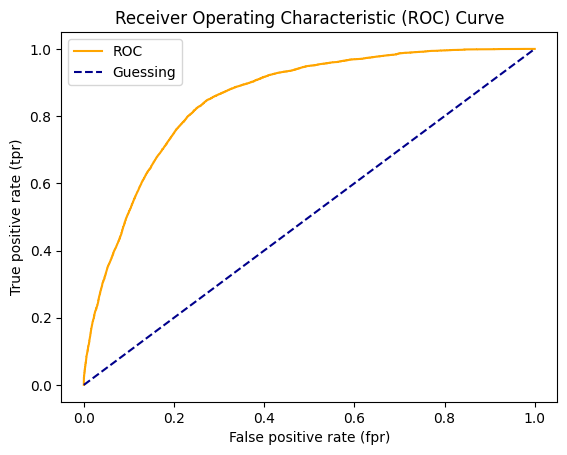


Results on TEST data:


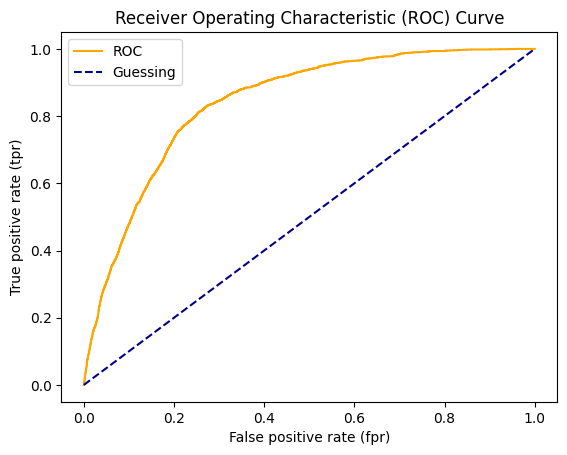

In [60]:
# ROC Curve
print("\nResults on TRAINING data:")
y_train_probs_positive = grid_search.best_estimator_.predict_proba(X_train_best_balanced)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_best_balanced, y_train_probs_positive)
Utility.plot_roc_curve(train_fpr, train_tpr)

print("\nResults on TEST data:")
y_test_probs_positive = grid_search.best_estimator_.predict_proba(X_test)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_probs_positive)
Utility.plot_roc_curve(test_fpr, test_tpr)

Classification Scores

In [61]:
# Scores
print("\nResults on TRAINING data:")
gridbest_train_scores = Utility.evaluate_preds(y_train_best_balanced, y_train_pred)

print("\nResults on TEST data:")
gridbest_test_scores = Utility.evaluate_preds(y_test, y_test_pred)


Results on TRAINING data:


Accuracy            :      79.34%
Precision           :       0.66
Recall              :       0.58
F1 score            :       0.62
F1 (macro) score    :       0.74
F1 (weighted) score :       0.79
ROC-AUC             :       0.73

Results on TEST data:
Accuracy            :      85.58%
Precision           :       0.25
Recall              :       0.54
F1 score            :       0.34
F1 (macro) score    :       0.63
F1 (weighted) score :       0.88
ROC-AUC             :       0.71


# Evaluate performance of `grid_search.best_estimator_` vs. the `balanced_clf` from before

In [62]:
#Recall df_compare definition from above
# df_compare = pd.DataFrame({
#     'baseline_train': baseline_train_scores,
#     'baseline_test': baseline_test_scores,
#     'balanced_train': balanced_train_scores,
#     'balanced_test': balanced_test_scores,
#     'hourint_train': hourint_train_scores,
#     'hourint_test': hourint_test_scores,
#     'simplify_train': simplify_train_scores,
#     'simplify_test': simplify_test_scores})

df_compare['gridbest_train'] = gridbest_train_scores
df_compare['gridbest_test'] = gridbest_test_scores
df_compare

,baseline_train,baseline_test,balanced_train,balanced_test,hourint_train,hourint_test,simplify_train,simplify_test,gridbest_train,gridbest_test
accuracy,0.93,0.93,0.78,0.83,0.78,0.83,0.73,0.82,0.79,0.86
precision,0.57,0.62,0.68,0.23,0.68,0.23,0.62,0.19,0.66,0.25
recall,0.00,0.00,0.66,0.63,0.66,0.63,0.51,0.48,0.58,0.54
f1,0.01,0.01,0.67,0.34,0.67,0.34,0.56,0.27,0.62,0.34
f1_macro,0.49,0.49,0.76,0.62,0.76,0.62,0.69,0.59,0.74,0.63
f1_weighted,0.90,0.90,0.78,0.86,0.78,0.86,0.73,0.86,0.79,0.88
roc_auc,0.50,0.50,0.75,0.74,0.75,0.74,0.68,0.66,0.73,0.71


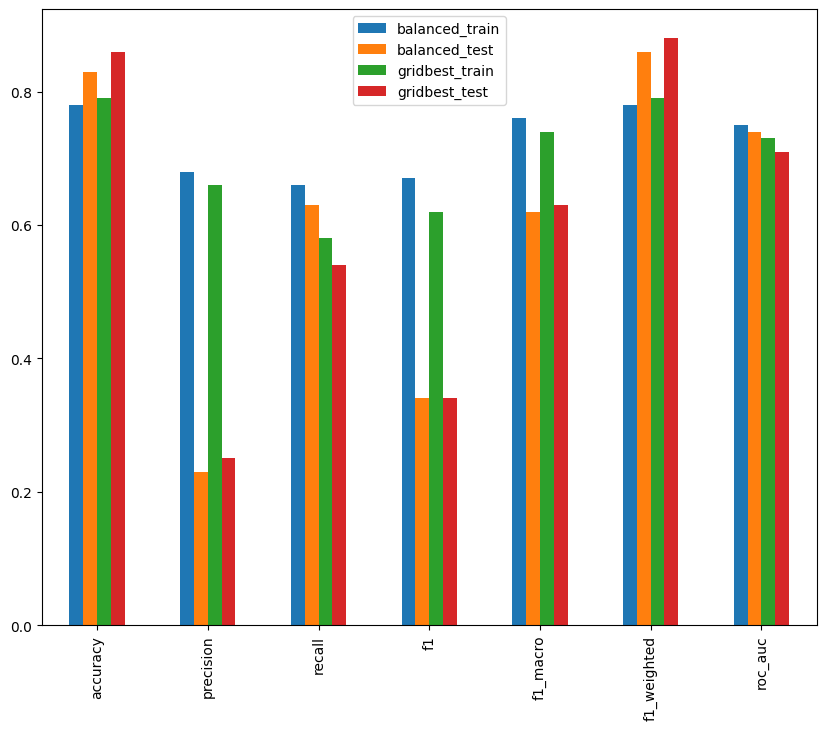

In [63]:
# Plot the scores
df_compare[['balanced_train', 'balanced_test', 'gridbest_train', 'gridbest_test']].plot.bar(figsize=(10,8));

Draw another graph comparing all scores only against the gridbest_test and balanced_test, since those are the ones that matter most (unseen data)

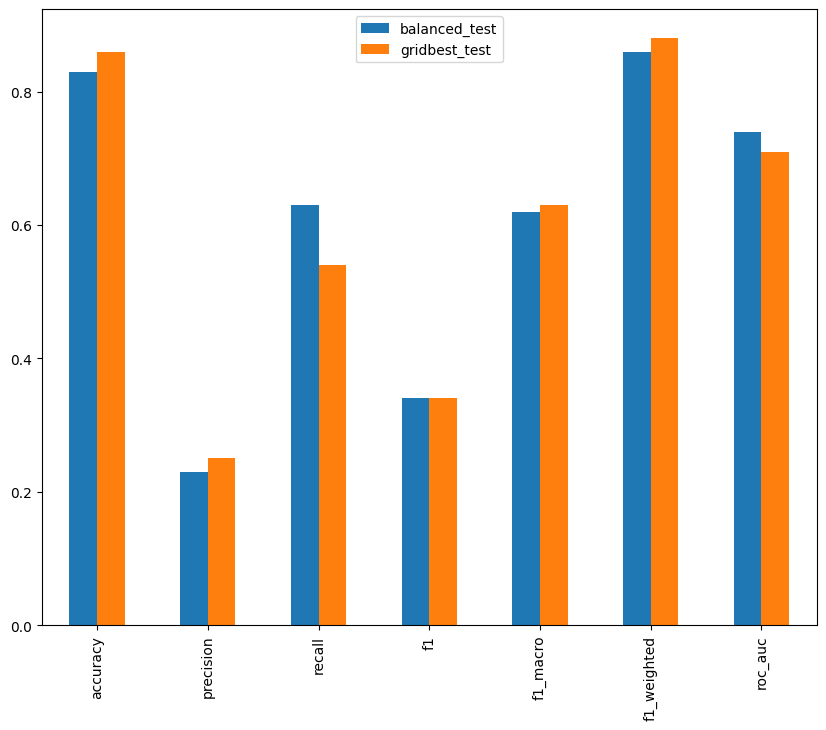

In [64]:
# Plot the scores
df_compare[['balanced_test', 'gridbest_test']].plot.bar(figsize=(10,8));

See the actual scores compared side by side on balanced_test vs. gridbest_test

In [65]:
df_compare[['balanced_test', 'gridbest_test']]

,balanced_test,gridbest_test
accuracy,0.83,0.86
precision,0.23,0.25
recall,0.63,0.54
f1,0.34,0.34
f1_macro,0.62,0.63
f1_weighted,0.86,0.88
roc_auc,0.74,0.71


Findings:  The GridSearchCV's best estimator performes slightly better on F1 Macro score (0.63 vs 0.62) (worse on roc_auc with 0.71 vs. 0.74).

We will use this as the model to compare against when we go into RandomForestClassifier and XGBoostClassifier next.

But, we will save both models just in case.

# Save the Models and `grid_search` object

Save:
* `balanced_clf`:  The best of the "regular logit" with SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.5, n_iter=1000
* `grid_search.best_estimator_`:  The best of the "regular_logit" with tuned SMOTE `sampling_strategy` = 0.1, Under `sampling_strategy` = 0.4, n_iter=500
* `grid_search`:  The grid_search object for future reference, where I can read `.best_params_`, `.cv_result_`, `.best_score_` in future if needed

In [66]:
# Setup paths and filenames

relativepath = Utility.MODELS_RELATIVE_PATH

#balanced_clf_filename = 'balanced_clf.pkl'
balanced_clf_filename = 'clf_balanced.pkl'

#grid_search_filename = 'smote_under_logit_grid_search.pkl'
grid_search_filename = 'grid_search_obj_logit_smote_under.pkl'

#grid_search_best_estimator_filename = 'smote01_under04_clf_iter500_grid_search_best_estimator.pkl'
grid_search_best_estimator_filename = 'clf_grid_search_best_estimator_smote01_under04.pkl'

In [67]:
# Write all 3 objects to disk

with open(relativepath + balanced_clf_filename, 'wb') as f:
    pickle.dump(balanced_clf, f)

with open(relativepath + grid_search_filename, 'wb') as f:
    pickle.dump(grid_search, f)

with open(relativepath + grid_search_best_estimator_filename, 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# Save the model results `df_compare` file

In [68]:
# Setup paths and filenames

relativepath_output = Utility.OUTPUT_RELATIVE_PATH
logit_scores_filename = 'logit_compare_model_scores.csv'

In [69]:
# Write csv to disk
df_compare.to_csv(relativepath_output + logit_scores_filename)